# Lyric Logic NLP Project
#### Mohamed Youssef - 211001821

## Index

-   [Including Necessary Libraries](#libs)
    <br>
-   [Other Utilites](#uti)
    <br>
-   [Loading the Data](#dataset)
    <br>
-   [Cleaning the Data](#clean)
    <br>
-   [Data Visualization](#vis)
    <br>
-   [Preprocessing the Data](#pre)
    <br>
<!-- -   [Neural Network Construction](#cnn)
    -   [Building the Network (Vgg Face Descriptor)](#bld)
    -   [Importing the Model's Weights](#wghts)
    <br>
-   [Predicting the Faces' Feature Map](#map)
    -   [Predicting the Faces' Feature Map for the Training Images](#train_map)
    -   [Predicting the Faces' Feature Map for the Testing Images](#test_map)
    <br>
-   [Finding Similarities Between the Images](#sim)
    -   [Finding Similarities between the Celebrities & the Testing Images](#test_sim)
    -   [Finding Similarities between the Celebrities & Each Other](#train_sim)
    <br>
-   [Getting the Predictions in Real Time](#real_time) -->


## Including Necessary Libraries<a id='libs'></a>


In [147]:
# Disable warnings (comment this cell to turn on warnings)
import warnings
import logging


def warn(*args, **kwargs):
    pass


warnings.warn = warn
logging.getLogger("tensorflow").disabled = True

In [148]:
import time  # For measuring time taken to run specific cells
import glob  # For getting testing images paths

import chime  # For making a sound when there is an error

import numpy as np  # For dealing with arrays and matrices
import pandas as pd  # For dealing with dataframes

import matplotlib.pyplot as plt  # For plotting images and graphs
from wordcloud import WordCloud # For plotting word clouds

# For building the CNN model
from keras.models import Sequential
from keras.layers import (
    Dropout,
    Flatten,
    Convolution2D,
    ZeroPadding2D,
    MaxPooling2D,
    LSTM,
)

import tensorflow as tf  # For configuring the GPU

## Other Utilites<a id='uti'></a>


In [149]:
# Setting the path to the dataset
dataset_path = "C:\Datasets\Song Lyrics Dataset"
print("Dataset path is: " + dataset_path)

Dataset path is: C:\Datasets\Song Lyrics Dataset


In [150]:
# Configuring the GPU for training the model

gpus = tf.config.list_physical_devices("GPU")  # Getting the list of GPUs available

# If there is a GPU available, then set the GPU to be used for training the model
if gpus:
    print("GPUs Available: ", gpus)

    # If there are two GPUs available, then use the second GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[1], "GPU")
        tf.config.experimental.set_memory_growth(gpus[1], True)

    # If there is only one GPU available, then use the first GPU
    except:
        tf.config.experimental.set_visible_devices(gpus[0], "GPU")
        tf.config.experimental.set_memory_growth(gpus[0], True)

# If there is no GPU available, then use the CPU
else:
    print("No GPU Available")

No GPU Available


In [151]:
# Initializing chime
chime.theme("sonic")
chime.notify_exceptions()

## Loading the Data <a id='dataset'></a>


In [152]:
# Getting the paths of the CSV files
csv_files_path = dataset_path + "\*.csv"
csv_files = glob.glob(csv_files_path)

In [153]:
print("CSV Files: ", csv_files)

CSV Files:  ['C:\\Datasets\\Song Lyrics Dataset\\ArianaGrande.csv', 'C:\\Datasets\\Song Lyrics Dataset\\Beyonce.csv', 'C:\\Datasets\\Song Lyrics Dataset\\BillieEilish.csv', 'C:\\Datasets\\Song Lyrics Dataset\\BTS.csv', 'C:\\Datasets\\Song Lyrics Dataset\\CardiB.csv', 'C:\\Datasets\\Song Lyrics Dataset\\CharliePuth.csv', 'C:\\Datasets\\Song Lyrics Dataset\\ColdPlay.csv', 'C:\\Datasets\\Song Lyrics Dataset\\Drake.csv', 'C:\\Datasets\\Song Lyrics Dataset\\DuaLipa.csv', 'C:\\Datasets\\Song Lyrics Dataset\\EdSheeran.csv', 'C:\\Datasets\\Song Lyrics Dataset\\Eminem.csv', 'C:\\Datasets\\Song Lyrics Dataset\\JustinBieber.csv', 'C:\\Datasets\\Song Lyrics Dataset\\KatyPerry.csv', 'C:\\Datasets\\Song Lyrics Dataset\\Khalid.csv', 'C:\\Datasets\\Song Lyrics Dataset\\LadyGaga.csv', 'C:\\Datasets\\Song Lyrics Dataset\\Maroon5.csv', 'C:\\Datasets\\Song Lyrics Dataset\\NickiMinaj.csv', 'C:\\Datasets\\Song Lyrics Dataset\\PostMalone.csv', 'C:\\Datasets\\Song Lyrics Dataset\\Rihanna.csv', 'C:\\Datasets\\

In [154]:
# Load the CSV files into a dataframe
df_list = []
for file in csv_files:
    df_list.append(pd.read_csv(file))

In [155]:
# Load the dataframes into a single dataframe
df = pd.concat(df_list, axis=0, ignore_index=True)

In [156]:
# Show 5 random rows from the dataframe
df.sample(5)

,Artist,Title,Album,Date,Lyric,Year,Unnamed: 0
2190,Dua Lipa,All of Me,NaN,2014-01-30,what would i do without your smart mouth drawi...,2014.0,93.0
1144,Cardi B,Thru Your Phone,Invasion of Privacy,2018-04-06,cardi b look i just want to break up all your ...,2018.0,7.0
4685,Nicki Minaj,Dirty Money (Freestyle),Playtime is Over,2007-07-05,i don't want to sound mad though i don't want ...,2007.0,188.0
1696,Drake,The Real Her,Take Care,2011-11-15,drake people around you should really have not...,2011.0,65.0
5418,Selena Gomez,Can’t Steal Our Love,Unreleased Songs,NaN,selena gomez i can't seem to hide from the lie...,NaN,45.0


In [157]:
# Describe the dataframe
df.describe()

,Year,Unnamed: 0
count,4278.000000,5719.000000
mean,2011.837775,175.362476
std,53.725459,121.678762
min,1.000000,0.000000
25%,2010.000000,71.000000
50%,2014.000000,156.000000
75%,2018.000000,263.000000
max,2022.000000,520.000000


In [158]:
# Checking for null values in the training data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6027 entries, 0 to 6026
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Artist      6027 non-null   object 
 1   Title       6027 non-null   object 
 2   Album       4453 non-null   object 
 3   Date        4278 non-null   object 
 4   Lyric       5981 non-null   object 
 5   Year        4278 non-null   float64
 6   Unnamed: 0  5719 non-null   float64
dtypes: float64(2), object(5)
memory usage: 329.7+ KB


In [159]:
# Show the number of null values in each column
df.isnull().sum()

Artist           0
Title            0
Album         1574
Date          1749
Lyric           46
Year          1749
Unnamed: 0     308
dtype: int64

In [160]:
# Show the names and the count of the unique artists in the dataset
df['Artist'].value_counts()

Artist
Eminem           521
Taylor Swift     479
Drake            466
Beyoncé          406
Rihanna          405
Lady Gaga        402
Justin Bieber    348
Coldplay         344
Katy Perry       325
Nicki Minaj      323
Ariana Grande    308
Ed Sheeran       296
BTS (방탄소년단)      278
Dua Lipa         247
Maroon 5         197
Selena Gomez     175
Post Malone      148
Billie Eilish    145
Charlie Puth      75
Cardi B           75
Khalid            64
Name: count, dtype: int64

In [161]:
# Display the lyrics of the first song in the dataset
df['Lyric'][0]

"thought i'd end up with sean but he wasn't a match wrote some songs about ricky now i listen and laugh even almost got married and for pete i'm so thankful wish i could say thank you to malcolm 'cause he was an angel  pre one taught me love one taught me patience and one taught me pain now i'm so amazing say i've loved and i've lost but that's not what i see so look what i got look what you taught me and for that i say   thank you next next thank you next next thank you next i'm so fuckin' grateful for my ex thank you next next thank you next next thank you next next i'm so fuckin'   spend more time with my friends i ain't worried 'bout nothin' plus i met someone else we havin' better discussions i know they say i move on too fast but this one gon' last 'cause her name is ari and i'm so good with that so good with that  pre she taught me love love she taught me patience patience how she handles pain pain that shit's amazing yeah she's amazing i've loved and i've lost yeah yeah but tha

## Clean the Data <a id='clean'></a>


In [162]:
# Remove unnecessary columns from the dataframe
df = df.drop(columns=["Album", "Date", "Unnamed: 0"])

In [163]:
# Rename the columns to more descriptive names
df.rename(columns={
    "Artist": "Artist Name",
    "Title": "Song Title",
    "Year": "Release Year",
    "Lyric": "Song Lyrics", 
}, inplace=True)

In [164]:
# Show 5 random rows from the dataframe
df.sample(5)

,Artist Name,Song Title,Song Lyrics,Release Year
3134,Eminem,Eminem - Zeus (ترجمه فارسی),تهیه شده توسط تیم اسلیم شیدی فن پیجمترجمطاها ...,2020.0
4499,Nicki Minaj,Barbie Dreams,uh mmm kyuh rip to big classic shit i'm loo...,2018.0
2644,Eminem,The Monster,rihanna i'm friends with the monster that's un...,2013.0
3184,Justin Bieber,Come Around Me,when you come around me treat me like you miss...,2020.0
3849,Khalid,Reasons,evade my intellect feed into my spect wrap you...,2016.0


In [165]:
# Remove rows where lyrics is null
df = df.dropna(subset=["Song Lyrics"])

In [166]:
# Remove any duplicate rows
df = df.drop_duplicates()

In [167]:
# Show the number of null values in each column
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5981 entries, 0 to 6026
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Artist Name   5981 non-null   object 
 1   Song Title    5981 non-null   object 
 2   Song Lyrics   5981 non-null   object 
 3   Release Year  4247 non-null   float64
dtypes: float64(1), object(3)
memory usage: 233.6+ KB


In [168]:
# Remove rows containing artists with less than 200 songs
df = df.groupby("Artist Name").filter(lambda x: len(x) > 200)

In [169]:
# Remove BTS from the dataset, (since I am not a fan of their music)
df = df[df["Artist Name"] != "BTS (방탄소년단)"]

In [170]:
# Show the names and the count of the unique artists in the dataset
df["Artist Name"].value_counts()

Artist Name
Eminem           521
Taylor Swift     477
Drake            464
Beyoncé          406
Rihanna          397
Lady Gaga        395
Justin Bieber    347
Coldplay         333
Katy Perry       324
Nicki Minaj      321
Ariana Grande    308
Ed Sheeran       294
Dua Lipa         246
Name: count, dtype: int64

In [171]:
# Show the release years and their counts
df["Release Year"].value_counts()

Release Year
2020.0    319
2011.0    289
2017.0    237
2019.0    234
2010.0    219
2009.0    209
2013.0    204
2016.0    198
2018.0    196
2014.0    177
2008.0    154
2015.0    150
2012.0    148
2007.0    123
2006.0    111
2002.0     59
2005.0     51
2003.0     50
2000.0     46
1999.0     36
2001.0     24
2021.0     23
2004.0     22
1998.0     13
1996.0     13
1997.0     10
1.0         3
1988.0      2
1990.0      2
2022.0      2
1729.0      1
1993.0      1
1982.0      1
Name: count, dtype: int64

In [172]:
# Remove any rows where the release year is less than 2000
df = df[df["Release Year"] >= 2000]

In [173]:
# Predict the missing values in the release year column using interpolation
df = df.interpolate(method="linear")

In [174]:
# Reset the index of the dataframe
df = df.reset_index(drop=True)

In [175]:
# Show the number of null values in each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3245 entries, 0 to 3244
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Artist Name   3245 non-null   object 
 1   Song Title    3245 non-null   object 
 2   Song Lyrics   3245 non-null   object 
 3   Release Year  3245 non-null   float64
dtypes: float64(1), object(3)
memory usage: 101.5+ KB


In [176]:
# Show the number of 

In [177]:
# Describe the dataframe
df.describe()

,Release Year
count,3245.000000
mean,2012.905393
std,5.138704
min,2000.000000
25%,2009.000000
50%,2013.000000
75%,2017.000000
max,2022.000000


In [178]:
# Show 5 random rows from the dataframe
df.sample(5)

,Artist Name,Song Title,Song Lyrics,Release Year
2208,Lady Gaga,Joanne,take my hand stay joanne heaven's not ready fo...,2016.0
2473,Nicki Minaj,Go Hard,nicki minaj tpain yosb holiday season nigga h...,2009.0
2100,Katy Perry,Never Really Over (R3HAB Remix),i'm losing my self control yeah you're startin...,2019.0
2216,Lady Gaga,Jewels N’ Drugs,ti yeah it's about that time yeah time ta take...,2013.0
2546,Nicki Minaj,Wheel of Freestyle,verse six sides thats a hexagon im the big hom...,2019.0


## Data Visualization <a id="vis"></a>


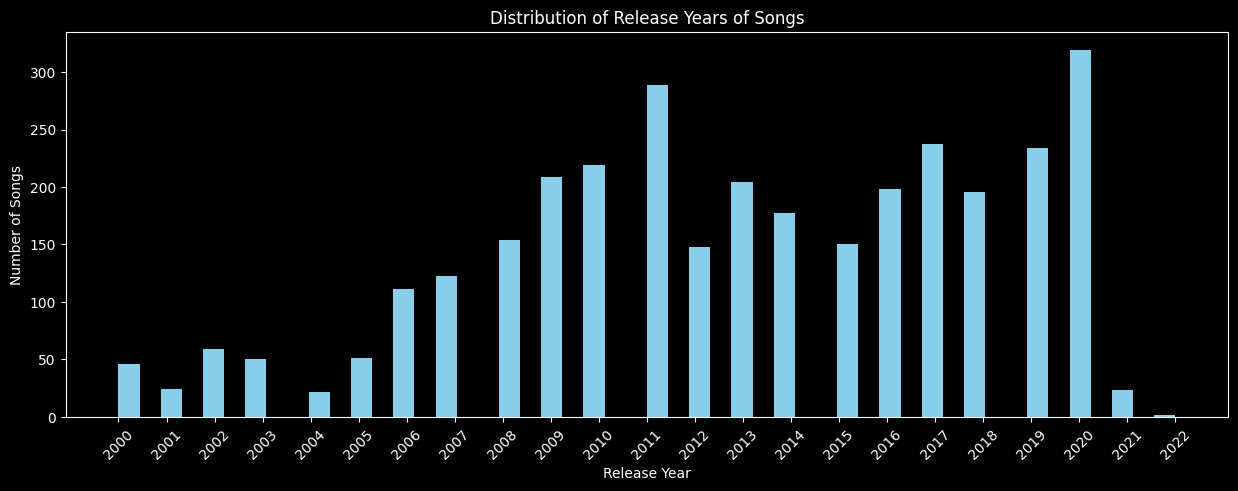

In [179]:
# Visualize the distribution of the release years of the songs
plt.figure(figsize=(15, 5))
plt.hist(df["Release Year"], bins=50, color="skyblue")
plt.xlabel("Release Year")
plt.ylabel("Number of Songs")
plt.xticks(np.arange(df["Release Year"].min(), df["Release Year"].max()+1), rotation=45)
plt.title("Distribution of Release Years of Songs")
plt.show()

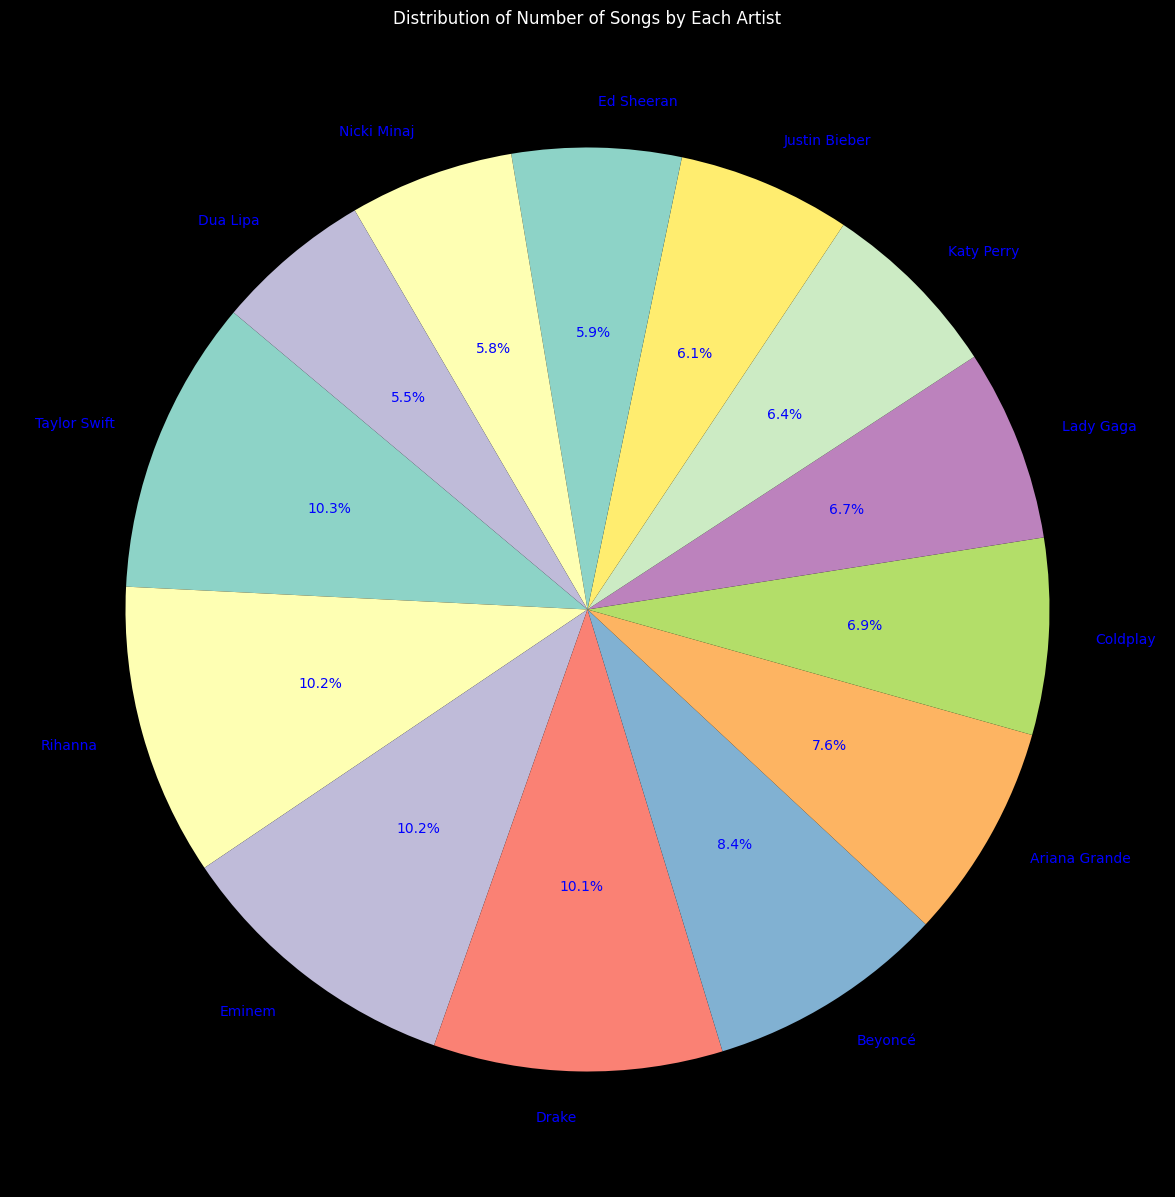

In [180]:
# Visualize the distribution of the number of songs by each artist
plt.figure(figsize=(15, 15))
df["Artist Name"].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, textprops={'color':"b"})
plt.title("Distribution of Number of Songs by Each Artist")
plt.ylabel("")
plt.show()

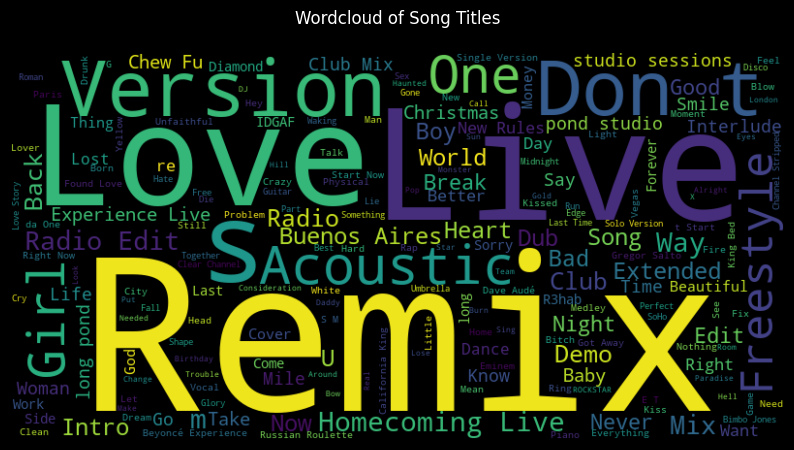

In [181]:
# Visualize words used in song titles using a wordcloud

# Get the song titles
song_titles = " ".join(df["Song Title"].values)

# Create a wordcloud
wordcloud = WordCloud(width=800, height=400, background_color="black").generate(song_titles)

# Display the wordcloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud of Song Titles\n")
plt.show()